# 全流程训练保存及预测

## 1. 训练及保存模型

In [1]:
# 导入
import sys

sys.path.append("E:/dataFiles/github/MFlow")

In [2]:
# 数据生成
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

# 加载MNIST数据集
xs, labels = fetch_openml("mnist_784", version=1, return_X_y=True)
xs, labels  = xs[:1000] / 255, labels.astype("uint8")[:1000]
# 转换为one-hot
ohe = OneHotEncoder(sparse=False)
ys = ohe.fit_transform(labels.reshape(-1, 1))
# 预处理
x_list = []
y_list = []
for i in range(xs.shape[0]):
    x_list.append(np.array(xs[i]).reshape(28, 28))
    y_list.append(np.array(ys[i]).reshape(10, 1))
xs = x_list
ys = y_list

print(len(xs), len(ys))
print(xs[0].shape, ys[0].shape)

1000 1000
(28, 28) (10, 1)


In [3]:
from mflow import core, metrics, models, ops, opts

# 超参数
lr = 0.005
epoch = 10
batch_size = 32

# 模型
x, output, predicter = models.MnistNet()
y = core.Variable(size=(10, 1), trainable=False)
loss = ops.loss.CrossEntropyWithSoftMax(output, y)
optimizer = opts.Adam(core.DefaultGraph, loss, lr)
metrics_list = [
    metrics.Accuracy(predicter, y, saved=True),
    # TODO: 支持多分类
    # metrics.Precision(predicter, y, saved=True),
    # metrics.Recall(predicter, y, saved=True)
]

In [4]:
from mflow import engine

# 训练
trainer = engine.SimpleTrainer(
    [x], y, loss, optimizer, epoch, batch_size, metrics_ops=metrics_list
)
trainer.trainEval(
    {x.name: xs[:900]}, ys[:900], 
    {x.name: xs[900:]}, ys[900:]
)

[Epoch 1] eval metrics: Accuracy: 0.8220 
[Epoch 2] eval metrics: Accuracy: 0.8590 
[Epoch 3] eval metrics: Accuracy: 0.8867 
[Epoch 4] eval metrics: Accuracy: 0.9040 
[Epoch 5] eval metrics: Accuracy: 0.9160 
[Epoch 6] eval metrics: Accuracy: 0.9247 
[Epoch 7] eval metrics: Accuracy: 0.9306 
[Epoch 8] eval metrics: Accuracy: 0.9347 
[Epoch 9] eval metrics: Accuracy: 0.9382 
[Epoch 10] eval metrics: Accuracy: 0.9418 


In [5]:
# 保存
saver = engine.Saver("output")
saver.save("MnistNet", core.DefaultGraph)

Save model into file: output\MnistNet.json.
Save weights to file: output\MnistNet.npz.


## 2. 加载模型及预测

In [6]:
# 导入
import sys

sys.path.append("E:/dataFiles/github/MFlow")

In [7]:
from mflow import core, engine

# 加载模型和参数
saver = engine.Saver("output")
saver.load("MnistNet", core.DefaultGraph)
x = core.getNodeByName("Input/Variable:0")
y = core.getNodeByName("Variable:74")
predicter = core.getNodeByName("SoftMax/SoftMax:73")

Load and restore model from output\MnistNet.


In [8]:
# 数据生成
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

# 加载MNIST数据集
xs, labels = fetch_openml("mnist_784", version=1, return_X_y=True)
xs, labels  = xs[1000:1100] / 255, labels.astype("uint8")[1000:1100]
# 转换为one-hot
ohe = OneHotEncoder(sparse=False)
ys = ohe.fit_transform(labels.reshape(-1, 1))
# 预处理
x_list = []
y_list = []
for i in range(xs.shape[0]):
    x_list.append(np.array(xs[i]).reshape(28, 28))
    y_list.append(np.array(ys[i]).reshape(10, 1))
xs = x_list
ys = y_list

print(len(xs), len(ys))
print(xs[0].shape, ys[0].shape)

100 100
(28, 28) (10, 1)


In [9]:
import numpy as np
from mflow import core, metrics

accuracy = metrics.Accuracy(predicter, y)

# 评估
for index in range(len(xs)):
    features = xs[index]
    label_onehot = ys[index]
    x.setValue(np.mat(features))
    y.setValue(np.mat(label_onehot))
    predicter.forward()
    accuracy.forward()

print("accuracy: {}.".format(accuracy.value))

accuracy: [[0.968]].


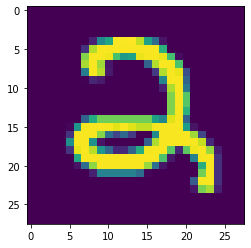

Infer: 2.


In [10]:
import matplotlib.pyplot as plt

%matplotlib inline

data = xs[48]
plt.imshow(data)
plt.show()

x.setValue(np.mat(data))
predicter.forward()
print("Infer: {}.".format(np.argmax(predicter.value)))